In [1]:
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt

from models.tfkeras_resnets import build_single_block_resnet, build_resnet

%matplotlib inline

In [2]:
blocks_resnet50  = [3, 4,  6, 3]
blocks_resnet101 = [3, 4, 23, 3]
blocks_resnet152 = [3, 8, 36, 3]

In [5]:
tf.keras.backend.clear_session()

resnet50 = build_resnet(image_size=(224,224,3),
                        kernel_type='antisymmetric',
                        include_top=True,
                        num_classes=1000,
                        subtract_mean=127.5,
                        divide_by_stddev=127.5,
                        version=1,
                        preset='resnet152',
                        blocks_per_stage=[3, 4, 6, 3],
                        filters_per_block=[[64, 64, 256],
                                           [128, 128, 512],
                                           [256, 256, 1024],
                                           [512, 512, 2048]],
                        use_batch_norm=True)

In [3]:
tf.keras.backend.clear_session()

simplified_resnet_antisymmetric = build_single_block_resnet(image_size=(28,28,1),
                                                            kernel_type='antisymmetric',
                                                            blocks_per_stage=blocks_resnet50,
                                                            filters_per_block=[16, 32, 64, 128],
                                                            num_classes=10,
                                                            use_batch_norm=False,
                                                            use_max_pooling=[False, False, True, False],
                                                            subtract_mean=127.5,
                                                            divide_by_stddev=127.5,
                                                            include_top=True)

In [4]:
for layer in resnet50.layers:
    print('{}:\t\t{}'.format(layer.name, layer.output.shape))

input_1:		(?, 224, 224, 3)
identity_layer:		(?, 224, 224, 3)
input_mean_normalization:		(?, 224, 224, 3)
input_stddev_normalization:		(?, 224, 224, 3)
conv1_pad:		(?, 230, 230, 3)
conv1:		(?, 112, 112, 64)
bn_conv1:		(?, 112, 112, 64)
activation:		(?, 112, 112, 64)
pool1_pad:		(?, 114, 114, 64)
stage1_pooling:		(?, 56, 56, 64)
res2_0_branch2a:		(?, 56, 56, 64)
bn2_0_branch2a:		(?, 56, 56, 64)
activation_1:		(?, 56, 56, 64)
res2_0_branch2:		(?, 56, 56, 64)
bn2_0_branch2b:		(?, 56, 56, 64)
activation_2:		(?, 56, 56, 64)
res2_0_branch1:		(?, 56, 56, 256)
res2_0_branch2c:		(?, 56, 56, 256)
bn2_0_branch1:		(?, 56, 56, 256)
add:		(?, 56, 56, 256)
activation_3:		(?, 56, 56, 256)
res2_1_branch2a:		(?, 56, 56, 64)
bn2_1_branch2a:		(?, 56, 56, 64)
activation_4:		(?, 56, 56, 64)
res2_1_branch2:		(?, 56, 56, 64)
bn2_1_branch2b:		(?, 56, 56, 64)
activation_5:		(?, 56, 56, 64)
res2_1_branch2c:		(?, 56, 56, 256)
add_1:		(?, 56, 56, 256)
activation_6:		(?, 56, 56, 256)
res2_2_branch2a:		(?, 56, 56, 64

In [4]:
mnist = tf.keras.datasets.mnist

(x_train, y_train),(x_test, y_test) = mnist.load_data()

x_train = np.expand_dims(x_train, axis=-1)
x_test = np.expand_dims(x_test, axis=-1)

print(x_train.shape)

(60000, 28, 28, 1)


In [5]:
simplified_resnet_antisymmetric.compile(optimizer='adam',
                                        loss='sparse_categorical_crossentropy',
                                        metrics=['accuracy'])

simplified_resnet_antisymmetric.fit(x_train, y_train, batch_size=32, epochs=1)
simplified_resnet_antisymmetric.evaluate(x_test, y_test)

Epoch 1/1
 3840/60000 [>.............................] - ETA: 9:42 - loss: 2.0516 - acc: 0.5130    

KeyboardInterrupt: 

In [11]:
i = np.random.randint(x_train.shape[0])

y_pred = simplified_resnet_antisymmetric.predict([[x_train[i]]])

np.set_printoptions(suppress=True, precision=4)

print('image name:\t{}'.format(i))
print('ground truth:\t{}'.format(y_train[i]))
print()
print('prediction:')
for k in range(len(y_pred[0])):
    print('{}:\t{:.2f}'.format(k, y_pred[0][k]))

image name:	55428
ground truth:	5

prediction:
0:	0.00
1:	0.00
2:	0.00
3:	0.00
4:	0.00
5:	0.99
6:	0.00
7:	0.00
8:	0.01
9:	0.00


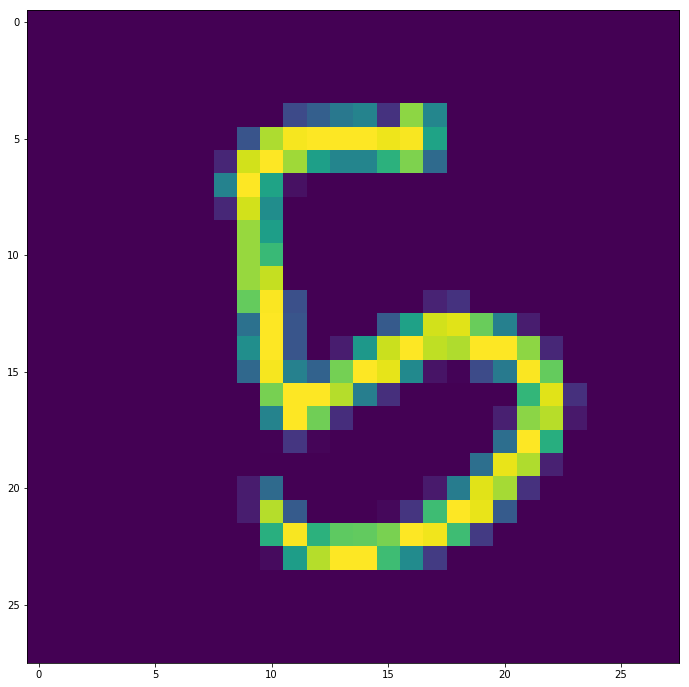

In [12]:
plt.figure(figsize=(20,12))
plt.imshow(np.squeeze(x_train[i]))

In [13]:
res2a_branch2 = simplified_resnet_antisymmetric.get_layer('res2a_branch2')
res2d_branch2 = simplified_resnet_antisymmetric.get_layer('res2d_branch2')

res2a_branch2_kernel = res2a_branch2.get_kernel()
res2d_branch2_kernel = res2d_branch2.get_kernel()

print(res2a_branch2_kernel[:,:,1,1])
print()
print(res2d_branch2_kernel[:,:,1,1])

[[ 0.0452 -0.0144  0.0407]
 [ 0.1174  0.     -0.1174]
 [-0.0407  0.0144 -0.0452]]

[[-0.002  -0.0845 -0.1493]
 [-0.0401  0.      0.0401]
 [ 0.1493  0.0845  0.002 ]]


In [30]:
for i in range(ord('a'), ord('a')+0):
    print('hello')

In [25]:
print(ord('a'))

97
